#### Project: AlexNet architecture

#### Packages selection
- The first things is to import all the neccesary packages needed for this project

In [9]:
import time
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt
%matplotlib inline

# selct GPU if cuda is available
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

#### Settings
- Configure the device
- define all the hyperparameters to be used and needed to be tuned to achive a better accuracy
- Load and explore the data

In [2]:
# device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# hyperparameters
RANDOM_SEED =1 
LEARNING_RATE = 0.001
BATCH_SIZE = 256
NUM_EPOCHS = 10

# model architecture parameters
NUM_CLASSES = 10

# datset -> CIFAR10
# Note: transform.ToTensor() scale image from 0-1 range
train_indices = torch.arange(0, 48000)
valid_indices = torch.arange(48000, 50000)

train_transform = transforms.Compose([transforms.Resize((70, 70)),
                                     transforms.RandomCrop((64, 64)),
                                     transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((70, 70)),
                                    transforms.CenterCrop((64, 64)),
                                    transforms.ToTensor()])

train_and_valid = datasets.CIFAR10(root='data',
                                  train=True,
                                  transform=train_transform,
                                  download=True)

train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)

test_dataset = datasets.CIFAR10(root='data',
                                train=False,
                                transform=test_transform,
                                download=False)





train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

Files already downloaded and verified


In [3]:
# check the train datasets
print("Training Set:\n")
for images, labels in train_loader:
    print("Image Batch dimensions:", images.size())
    print("Image Labels dimensions:", labels.size())
    break
    
# check valid Set
print("\nValidation Set:")
for images, labels in valid_loader:
    print("Image Batch dimensions", images.size())
    print("Image Labels dimension", labels.size())
    break
    
# check test Set
print("\nTesting Set:")
for images, labels in test_loader:
    print("Image Batch dimension", images.size())
    print("Image Labels dimension", labels.size())
    break

Training Set:

Image Batch dimensions: torch.Size([256, 3, 64, 64])
Image Labels dimensions: torch.Size([256])

Validation Set:
Image Batch dimensions torch.Size([256, 3, 64, 64])
Image Labels dimension torch.Size([256])

Testing Set:
Image Batch dimension torch.Size([256, 3, 64, 64])
Image Labels dimension torch.Size([256])


#### Define the architecture of the model such as
- The number of input layers; which is determined by the features of the data
- Number of total hidden layers in the model consist of Convolution layers, Pooling layers and fully connected layers
- The output layer node units is determined by the intended outcome to achieve

In [4]:
"""
Architecture:
"""

class AlexNet(nn.Module):
    
    def __init__(self, NUM_CLASSES):
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, NUM_CLASSES)
        )
        
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        outputs = self.classifier(x)
        probas = F.softmax(outputs, dim=1)
        return outputs, probas 

#### Loss function and optimizer
- Instantiate the model
- define the specific Loss function to be used either cross entropy, MSELoss, etc
- define the optimization algorithm to be used either SGD, Adam, RMSprop, Momentum etc.

In [5]:
torch.manual_seed(RANDOM_SEED)
model = AlexNet(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### compute accuracy
- A function to compute train and test accuracy

In [6]:
def compute_accuracy(model, data_loader):
    correct_predictions, num_examples = 0, 0
    for features, labels in data_loader:
        features = features.to(device)
        labels = labels.to(device)
        output, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += labels.size(0)
        correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / num_examples * 100

#### Training a model requires the following steps
- Reset all the gradients to zero (0)
- Make a forward pass (make a prediction)
- Calculate the loss
- Perform back propagation
- Update all the parameters (weight and biases)

In [7]:
start_time = time.time()
total_step = len(train_loader)

cost_list = []

train_acc_list, valid_acc_list = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    for i, (features, labels) in enumerate(train_loader):
        
        features = features.to(device)
        labels = labels.to(device)
        
        # Forward and back prop
        output, probas = model(features)
        loss = F.cross_entropy(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        cost_list.append(loss.item())
        if not i % 150:
            print(f'Epoch: {epoch+1:03d} / {NUM_EPOCHS:03d} | '
                 f'Batch: {i:03d} / {total_step:03d} | '
                 f'Cost: {loss:.4f}')
    model.eval()
    with torch.set_grad_enabled(False): # save the memory inference
        
        train_acc = compute_accuracy(model, train_loader)
        valid_acc = compute_accuracy(model, valid_loader)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
             f'Train Acc: {train_acc:.2f} | Validation Acc: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')
            

Epoch: 001 / 010 | Batch: 000 / 188 | Cost: 2.3030
Epoch: 001 / 010 | Batch: 150 / 188 | Cost: 2.3033
Epoch: 001/010
Train Acc: 10.03 | Validation Acc: 9.35
Time elapsed: 10.29 min
Epoch: 002 / 010 | Batch: 000 / 188 | Cost: 2.3030
Epoch: 002 / 010 | Batch: 150 / 188 | Cost: 2.3025
Epoch: 002/010
Train Acc: 9.97 | Validation Acc: 10.75
Time elapsed: 20.18 min
Epoch: 003 / 010 | Batch: 000 / 188 | Cost: 2.3030
Epoch: 003 / 010 | Batch: 150 / 188 | Cost: 2.3026
Epoch: 003/010
Train Acc: 10.06 | Validation Acc: 8.60
Time elapsed: 28.85 min
Epoch: 004 / 010 | Batch: 000 / 188 | Cost: 2.3025
Epoch: 004 / 010 | Batch: 150 / 188 | Cost: 2.3026
Epoch: 004/010
Train Acc: 10.00 | Validation Acc: 10.10
Time elapsed: 37.98 min
Epoch: 005 / 010 | Batch: 000 / 188 | Cost: 2.3023
Epoch: 005 / 010 | Batch: 150 / 188 | Cost: 2.3027
Epoch: 005/010
Train Acc: 10.06 | Validation Acc: 8.60
Time elapsed: 47.19 min
Epoch: 006 / 010 | Batch: 000 / 188 | Cost: 2.3032
Epoch: 006 / 010 | Batch: 150 / 188 | Cost:

#### Evaluation

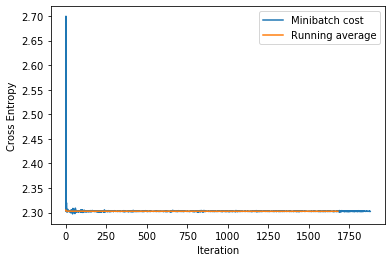

In [11]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200, )/200, mode='valid'),
                    label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

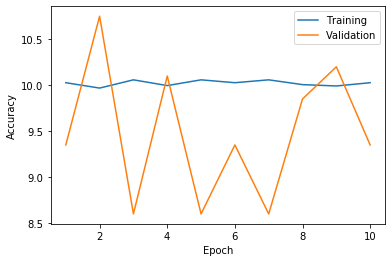

In [13]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
with torch.set_grad_enabled(False):
    test_acc = compute_accuracy(model=model,
                          data_loader=test_loader)
    
    valid_acc = compute_accuracy(model=model,
                           data_loade=valid_loader)
    
print(f'Validation Acc: {valid_acc:.2f}%')
print(f'Test Acc: (test_acc:.2f)%')